### Problem Set 6-1 - Exploratory Work

<b>Arnie Larson</b>

This notebook contains notes and code exploring the data processing techniques discussed in class.

Of particular note is:

Averaging a Source Level to obtain a PSD.

Using Windowing to supproess sidelobes from a known source.

Using Zero padding to increase frequency resolution

**Todo**

- [ ] Load data sets (n rows x m columns), 1 column for each series
- [ ] Apply Hann window to data
- [ ] Renormalize energy correctly (I take the sum(PSD)*dF for the raw and windowed data and spot check)
- [ ] Implement averaging (sum over rows of PSD to get an averaged value at specified frequency)


In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
import scipy.io as io
import os

In [193]:
# Load data
ambient="data/ME525/PS6/Ambient-2.csv"
p1=np.genfromtxt(os.path.join(os.getcwd(),ambient), delimiter=",",dtype=np.float32)

In [194]:
p1.shape

(96000, 30)

In [198]:
p1[1,:].shape
p1[:10,2]

array([-0.30059 , -0.2384  , -0.20731 , -0.27468 , -0.14511 , -0.067374,
       -0.24877 , -0.18657 , -0.093287, -0.15548 ], dtype=float32)

In [199]:
# Algorithm for processing sets of windows
# remove mean
# calculate energy (Sum[p*p]*dt)
# apply window (p -> w*p)
# calculate energy again (Sum[p*p]*dt)
# renormalize energy (p -> Ep/Ew * p)
# 
p1.mean(axis=0)

array([-0.00992236,  0.35350385,  0.10229133, -0.0557647 ,  0.26067373,
        0.17238994, -0.18634343, -0.55464095, -0.22501095,  0.02295289,
        0.21153489,  0.50391674,  0.21775004, -0.34752095, -0.4095186 ,
        0.05200649,  0.40578824,  0.37556493, -0.3120676 , -0.44015357,
       -0.0778271 ,  0.03867229, -0.03642468, -0.20382775,  0.05553717,
        0.24947292,  0.32067388,  0.14026095,  0.20221454,  0.02221365],
      dtype=float32)

In [200]:
p2 = p1 - p1.mean(axis=0)

In [125]:
# look at the plots of the pressure  (these are each 1 Second windows, each with 96k samples)
T=1; fs = 96000;  DT= 1/fs;  Ns = 96000;
t=np.linspace(0,T-1/fs, Ns)

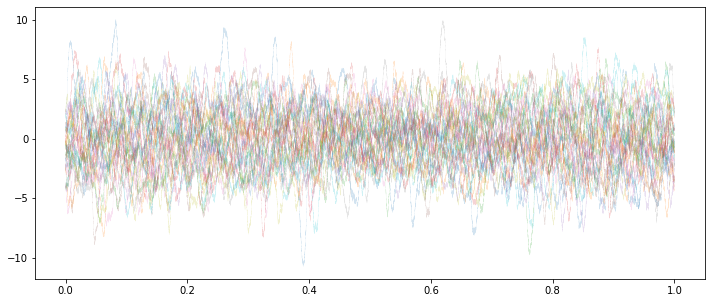

In [349]:
plt.subplots(figsize=(12,5))
plt.plot(t,p2,alpha=0.2, linewidth=0.2)
plt.show()

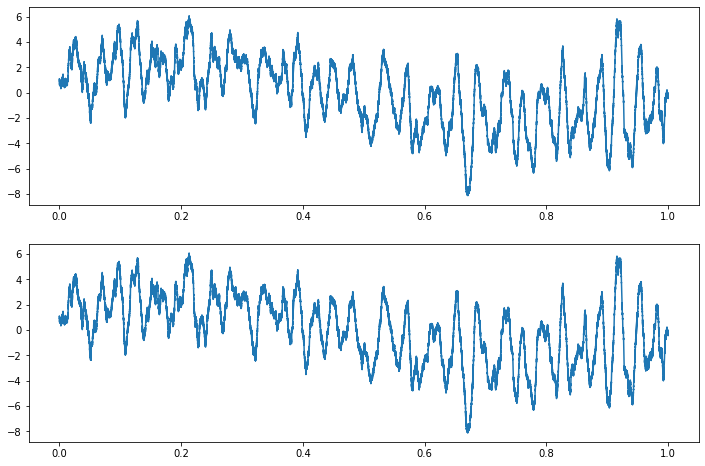

In [204]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,8))
ax1.plot(t,p1[:,0])
ax2.plot(t,p2[:,0])
plt.show()

In [206]:
p2[:,0].mean()

1.4597575e-06

In [350]:
# what is time energy?
(p2*p2).sum(axis=0)*DT
E2=(p2*p2).sum(axis=0)*DT
E2[:5]

array([7.340644 , 3.8824215, 2.5099812, 4.217944 , 4.415677 ],
      dtype=float32)

In [208]:
# Add a Hahn window**, will change the power by about sqrt(8/3)
#w1=(1/N)*np.power(np.cos(np.pi*t/N),2)

w1=(0.5-0.5*np.cos(2*np.pi*t))   # appears to be same as w2 = signal.windows.hann(N)

p3=np.zeros_like(p2)
for col in range(p2.shape[1]):
    p3[:,col]=w1*p2[:,col]

In [209]:
E3=(p3*p3).sum(axis=0)*DT

In [210]:
p3.shape

(96000, 30)

In [211]:
E3=(p3*p3).sum(axis=0)*DT
# renormalize energy
for col in range(p3.shape[1]):
    p3[:,col]=np.sqrt(E2[col]/E3[col])*p3[:,col]

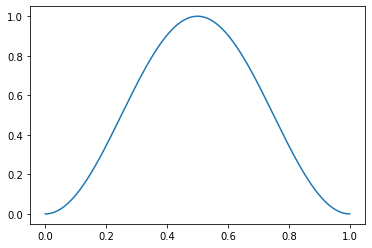

In [212]:
w2 = signal.windows.hann(N)
plt.plot(t,w2)

In [270]:
f.shape

(240000,)

Energy in E2 (raw): 6.95868767395081 [Pa^2]
Energy in E3 (windowed): 6.958803787566704 [Pa^2]
Compare to energy at index 5: 6.958459377288818 [Pa^2]


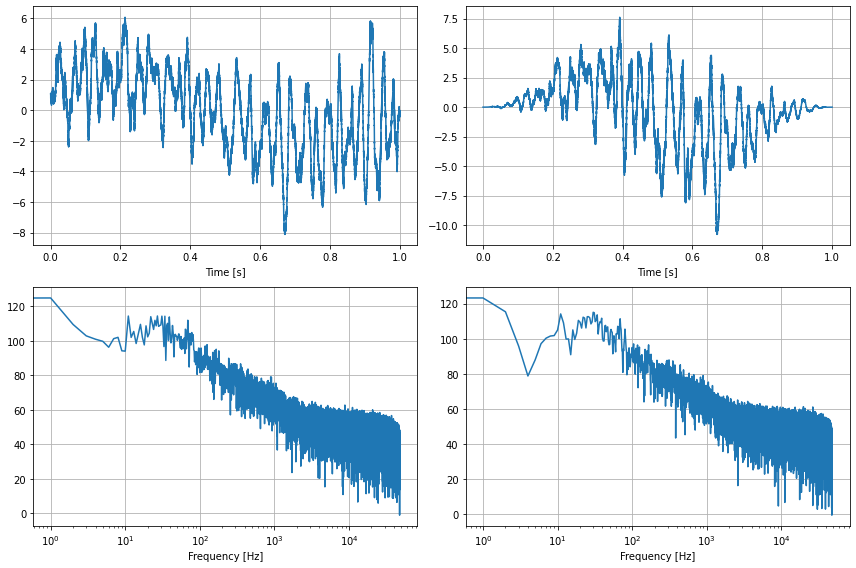

In [279]:
# Get PSD's
# N and DT are given above
# idx is index to one of the timeseries

N=t.shape[0]; DT2 = t[1] - t[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
# scale N by 5 (zero padding of FFT)
#N=5*N; DF/=5
idx=5
F2=np.abs(fft(p2[:,idx]))/N               # fourier spectrum
F3=np.abs(fft(p3[:,idx]))/N               # fourier spectrum of windowed
#F2=np.abs(fft(p2[:,idx], n=N))/(N)               # fourier spectrum
#F3=np.abs(fft(p3[:,idx], n=N))/(N)               # fourier spectrum of windowed
f=fftfreq(N, DT)[:N//2] 
#f3=fftfreq(N3, DT3)[:N3//2] 
PSD2=2*F2[0:N//2]*F2[0:N//2]            # should remove half of the DC energy
PSD2[0]=PSD2[0]/2
print("Energy in E2 (raw): {} [Pa^2]".format(PSD2.sum()*DF))
EF3=PSD3.sum()*DF
PSD_db2 = 10*np.log10(PSD2/(1e-6)**2)
PSD3=2*F3[0:N//2]*F3[0:N//2]      # should remove half of the DC energy
PSD3[0]=PSD3[0]/2
print("Energy in E3 (windowed): {} [Pa^2]".format(PSD3.sum()*DF))
print("Compare to energy at index {}: {} [Pa^2]".format(idx, E2[idx]))
PSD_db3 = 10*np.log10(PSD3/(1e-6)**2)

fig, ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].plot(t,p2[:,0]); ax[0,0].set_xlabel("Time [s]")
ax[0,1].plot(t,p3[:,0]); ax[0,1].set_xlabel("Time [s]")
#ax[1,0].plot(f, PSD_db2)
#ax[1,1].plot(f, PSD_db3)
ax[1,0].semilogx(f, PSD_db2); ax[1,0].set_xlabel("Frequency [Hz]")
ax[1,1].semilogx(f, PSD_db3); ax[1,1].set_xlabel("Frequency [Hz]")
ax[0,0].grid(); ax[0,1].grid();
ax[1,1].grid(); ax[1,0].grid();
fig.tight_layout()
plt.show()

In [332]:
 
N=t.shape[0]; DT2 = t[1] - t[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
#N=5*N   # try to do zero padding
PSD=np.zeros((48000,30))
for col in range(PSD.shape[1]):
    #F=np.abs(fft(p2[:,col]))/N               # fourier spectrum of windowed
    F=np.abs(fft(p3[:,col], n=N))/N               # fourier spectrum of windowed
    f=fftfreq(N, DT)[:N//2] 
    #f3=fftfreq(N3, DT3)[:N3//2] 
    psd=2*F[0:N//2]*F[0:N//2]            # should remove half of the DC energy
    psd[0]=psd[0]/2
    PSD[:,col]=psd


In [333]:
PSD.shape

(48000, 30)

In [334]:
PSDdb=10*np.log10(PSD/(1e-6)**2)

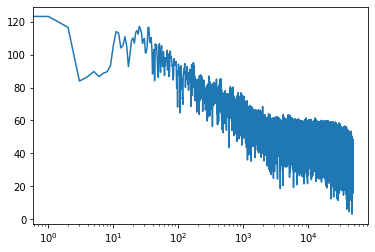

In [344]:
plt.semilogx(f,PSDdb[:,0])

In [336]:
PSD_sum=PSD.sum(axis=1)/PSD.shape[1]
PSD_sum_db=10*np.log10(PSD_sum/(1e-6)**2)
PSD_db=10*np.log10(PSD/(1e-6)**2)

In [337]:
print("Energy in E2 (raw): {} [Pa^2]".format(PSD_sum.sum()*DF))
f.shape

Energy in E2 (raw): 6.297581367226527 [Pa^2]


(48000,)

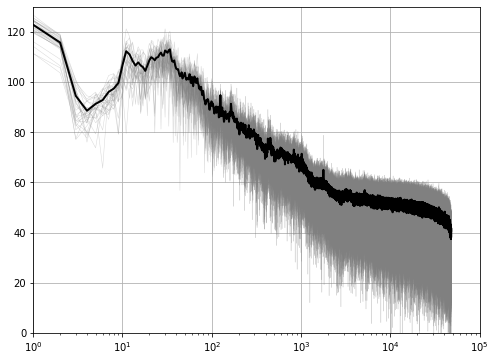

In [347]:
plt.subplots(figsize=(8,6))

plt.semilogx(f, PSD_db, color='grey', linewidth=0.5,alpha=0.3)
plt.semilogx(f, PSD_sum_db, color='black', linewidth=2.0)
plt.ylim(0,130)
plt.xlim(1,100000)
plt.grid()
plt.savefig("ambient-testplot.pdf")

In [324]:
 
N=t.shape[0]; DT2 = t[1] - t[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
#N=5*N   # try to do zero padding
# Should be able to vectorize the FFT
F=np.abs(fft(p3, axis=0))/N  
f=fftfreq(N, DT)[:N//2] 
psd=2*F[0:N//2,:]*F[0:N//2,:]            # should remove half of the DC energy
psd.shape

In [329]:

psddb=10*np.log10(psd/(1e-6)**2)

#print("Energy in E(windowed): {} [Pa^2]".format(psd[:,4].sum()*DF))

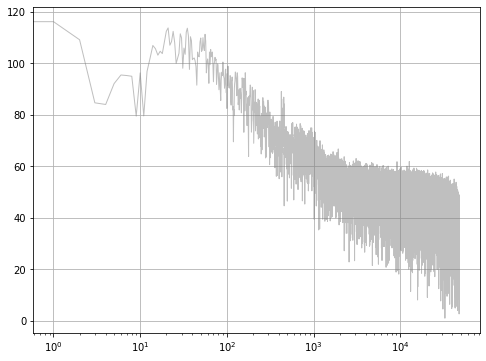

In [331]:
plt.subplots(figsize=(8,6))
#plt.semilogx(f, psd, color='black', linewidth=4.0)
plt.semilogx(f, psddb[:,1], color='grey', linewidth=1.0,alpha=0.5)
#plt.ylim(0,130)
#plt.xlim(0,10000)
plt.grid()
plt.show()
#plt.savefig("ambient-testplot.pdf")

In [351]:
# Vessel Receive
# Load data
vessel="data/ME525/PS6/VesselNoiseTimeseries.csv"
pv1=np.genfromtxt(os.path.join(os.getcwd(),vessel), delimiter=",",dtype=np.float32)

In [352]:
pv1.shape

(96000, 41)

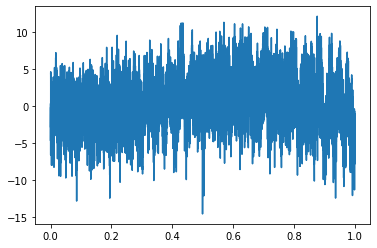

In [354]:
plt.plot(t,pv1[:,0])
plt.
plt.show()